In [1]:
!pip install simpy scikit-learn pandas numpy matplotlib


In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


In [3]:
def queue_simulation(arrival_rate, service_rate, queue_capacity, simulation_time):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)

    wait_times = []
    system_times = []
    busy_time = 0

    def customer(env):
        nonlocal busy_time
        arrival_time = env.now

        with server.request() as req:
            yield req
            wait = env.now - arrival_time
            wait_times.append(wait)

            service_time = random.expovariate(service_rate)
            busy_time += service_time
            yield env.timeout(service_time)

            system_times.append(wait + service_time)

    def arrival_process(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            if len(server.queue) < queue_capacity:
                env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=simulation_time)

    return (
        np.mean(wait_times) if wait_times else 0,
        np.mean(system_times) if system_times else 0,
        busy_time / simulation_time
    )


In [4]:
def random_parameters():
    return {
        "arrival_rate": np.random.uniform(0.2, 2.0),
        "service_rate": np.random.uniform(0.5, 3.0),
        "queue_capacity": np.random.randint(5, 51),
        "simulation_time": np.random.randint(50, 301)
    }


In [5]:
data = []

for _ in range(1000):
    params = random_parameters()

    avg_wait, avg_system, utilization = queue_simulation(**params)

    data.append({
        **params,
        "avg_wait_time": avg_wait,
        "avg_system_time": avg_system,
        "server_utilization": utilization
    })

df = pd.DataFrame(data)
df.head()


,arrival_rate,service_rate,queue_capacity,simulation_time,avg_wait_time,avg_system_time,server_utilization
0,0.226995,1.999306,37,226,0.039583,0.440666,0.069214
1,1.195532,2.182478,19,263,1.008629,1.486467,0.610424
2,0.571316,2.949749,25,80,0.042787,0.357886,0.202848
3,0.865148,1.726609,38,61,0.193380,0.669400,0.312145
4,1.478866,2.866391,27,70,0.324663,0.662616,0.491521


In [6]:
df.describe()



,arrival_rate,service_rate,queue_capacity,simulation_time,avg_wait_time,avg_system_time,server_utilization
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.100811,1.752722,27.24600,175.096000,4.714690,5.398906,0.617344
std,0.512204,0.710163,13.31378,72.960044,8.856330,9.091626,0.288763
min,0.203742,0.500009,5.00000,50.000000,0.000000,0.247857,0.056911
25%,0.664521,1.147261,15.00000,114.750000,0.260870,0.734780,0.379293
50%,1.102017,1.751728,27.00000,173.000000,0.757256,1.372190,0.616815
75%,1.530226,2.365783,39.00000,239.000000,4.014783,4.705399,0.906101
max,1.997217,2.994328,50.00000,300.000000,55.717939,57.496459,1.050334


In [7]:
X = df[["arrival_rate", "service_rate", "queue_capacity", "simulation_time"]]
y = df["avg_wait_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df

,Model,MAE,RMSE,R2
1,Random Forest,1.129218,2.616412,0.897234
4,Decision Tree,1.633141,3.983716,0.761760
0,Linear Regression,4.628847,6.190630,0.424683
3,KNN,5.987348,8.795106,-0.161234
2,SVR,3.871144,8.817709,-0.167210


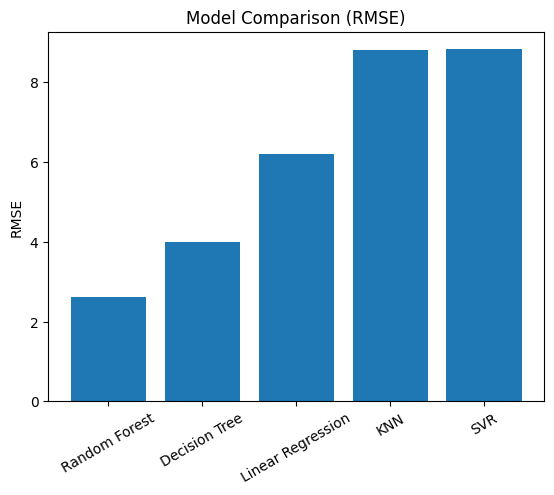

In [11]:
plt.figure()
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xticks(rotation=30)
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.show()


In [12]:
best_model = results_df.iloc[0]["Model"]
print("Best ML model based on RMSE:", best_model)


Best ML model based on RMSE: Random Forest
